# Identifying the Problem Pairs

While it is important to measure the performance of the trains and potential impact on BART commuters, it is perhaps more important to identify the potential problem segments where delays are introduced.

A journey is made up many segments of stations. Delays introduced at individual segment can add up to impact the entire journey. 

In this analysis, we will compare the scheduled travel time and actual travel times between subsequent stations.

Identifying certain _hot-spots_ it give us a direction for deeper investigation into the cause and potential solutions.

## Libraries and Imports
Stand on the shoulder of giants. Use the collective innovations of open source.

In [1]:
import pandas as pd
# Configure some display options for panda frames to ensure we see all columns and rows when needed.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 6)
pd.set_option('display.max_colwidth', -1)

import datetime as dt

# Ensure we embedd the graphs we generate within the Notebook
%matplotlib inline

import numpy as np
from scipy import stats

import seaborn as sns
sns.set(color_codes=True)

import pickle

import pprint

# For Maps
import folium

# Classes
We have a couple of simple Container classes to hold information that that we load in. These can be moved into a common python library that can be used across multiple BART applications and packages.

In [2]:
class TravelRecord(object):
    def __init__(self, row_a, row_b):
        """Represents a TravelRecord between two locations, including the start, end times as well as durations."""
        self._location_a = row_a['location']
        self._location_b = row_b['location']
        self._start_time = row_a['received_time']
        self._end_time = row_b['received_time']
        self._travel_time_secs = (self._end_time - self._start_time).total_seconds()
        
    def __str__(self):
        ret = "{} @ {} --[{}]--> {} @ {}".format(self._location_a, self._start_time, self._travel_time_secs, self._location_b, self._end_time)
        return ret
    
    def __repr__(self):
        return self.__str__()

In [3]:
class TravelStatistics(object):
    def __init__(self, start, end, list_travel_times):
        """Given a TravelRecord with multiple trips, generates statistics including:
         * stats.describe.
         * median (i.e. p50
         * p90
         * p99
         * p99.9
         """
        self._start = start
        self._end = end
        np_array = np.sort(np.fromiter(list_travel_times, np.float))
        
        percentiles = np.percentile(np_array, [50, 75, 90, 95, 99])
        self._p50 = percentiles[0]
        self._p75 = percentiles[1]
        self._p90 = percentiles[2]
        self._p95 = percentiles[3]
        self._p99 = percentiles[4]
        
        stats_obj = stats.describe(np_array)
        self._nobs = stats_obj.nobs
        self._min = stats_obj.minmax[0]
        self._max = stats_obj.minmax[1]
        self._mean = stats_obj.mean
        self._variance = stats_obj.variance
        self._skewness = stats_obj.skewness
        self._kurtosis = stats_obj.kurtosis
        self._mode = stats.mode(np_array)
        
    def __str__(self):
        ret = "start={}, end={}".format(self._start, self._end)
        ret += ", nobs={}, min={}, max={}, mode={}".format(self._nobs, self._min, self._max, self._mode)
        ret += ", p50={}, p75={}, p90={}, p95={}, p99={}".format(self._p50, self._p75, self._p90, self._p95, self._p99)
        ret += ", mean={}, variance={}".format(self._mean, self._variance)
        ret += ", skewness={}, kurtosis={}".format(self._skewness, self._kurtosis)        
        return ret

    def __repr__(self):
        return self.__str__() 


# Data

Lets load in the data that we'll use in this analysis. The main datasets are:
1. Time Table - filtered subset of _E_TIME_TABLE_ focusing on current timetable only.
2. BART Stations Location - for geo-spatial plotting.
3. Scheduled Travel Statistics - Derived from the _Time Table_ to get expected travel times between adjacent station pairs.
4. Actual Travel Records from JSON data - Derived from the sample of the JSON sensor data, containing list of TravelRecords between adjacent station pairs.
5. Actual Travel Statistics from the Travel Records - Derived from _Actual Travel Records_ to get statistics on the actual travel times between adjacent station pairs.

### Time Table (Current)

In [4]:
time_table = pd.read_csv('tt_of_interest_no_index.csv')
time_table.head()

,SCH_DAY_TYPE_CODE,ROUTE_B_NUMBER,TRAIN_NUMBER,RUN_U_NUMBER,STATION_O_NUMBER,STATION_CH3_ABBR,STATION_NAME,DOOR_CLOSE_TIME,DOOR_CLOSE_TSEC,DOOR_OPEN_TSEC,LINE_NUMBER,ROUTE_ABBR,MAP_COLOR_NAME,FROM_STATION_O_NUM,TO_STATION_O_NUM,FROM_STATION_CH3_ABBR,TO_STATION_CH3_ABBR,FROM_STATION,TO_STATION
0,SA,1,361,5,41,C80,WEST PITTSBURG,2017-08-15 06:58:23,25103,24983.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
1,SA,1,361,5,40,C70,NORTH CONCORD,2017-08-15 07:04:30,25470,25455.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
2,SA,1,361,5,19,C60,CONCORD,2017-08-15 07:08:04,25684,25669.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
3,SA,1,361,5,18,C50,PLEASANT HILL,2017-08-15 07:13:28,26008,25993.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
4,SA,1,361,5,17,C40,WALNUT CREEK,2017-08-15 07:16:05,26165,26150.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT


### BART Station Locations

In [5]:
bart_locations = pd.read_csv('bart_locations.csv')
print bart_locations.shape
bart_locations.head(5)
#print bart_locations[bart_locations.isnull().any(axis=1)]

(44, 37)


,station_q_number,Country,station_ch5_abbr,station_ch8_abbr,station_p_number,station_o_number,city,station_r_number,county,bart_station_geo_country_geo_city,station_abbr,bart_station_geo_country_geo_postcode,geo_address,line_number,bart_station_geo_country_geo_region,id,state,abbr,bart_station_geo_country_geo_regionid,station_name,address,bart_station_geo_country_geo_subregion,bart_station_geo_country_geo_geocode,station_ch3_abbr,bart_station_geo_country_geo_country,bart_station_geo_country_geo_subregionid,zipcode,plat1_displ_number,gtfs_latitude,name,station_m_number,gtfs_longitude,plat4_displ_number,station_ch4_abbr,plat2_displ_number,plat3_displ_number,Source_data_set|
0,27,United States,MONTG,MONTGMRY,27,27,San Francisco,41,sanfrancisco,San Francisco,MT,94172,37.789256 -122.401407,1,California,MT,CA,MONT,5332921,MONTGOMERY STREET,598 Market Street,City And County Of San Francisco,37.77493 -122.41942,M20,US,5391997.0,94104,16,37.789256,MONTGOMERY ST.,31.0,-122.401407,0,MONT,17,0,bart_locations|station_list
1,32,United States,GLNPK,GLEN PRK,32,32,San Francisco,46,sanfrancisco,San Francisco,GP,94172,37.732921 -122.434092,1,California,GP,CA,GLEN,5332921,GLEN PARK,2901 Diamond Street,City And County Of San Francisco,37.77493 -122.41942,M70,US,5391997.0,94131,6,37.732921,GLEN PARK,36.0,-122.434092,0,GLEN,7,0,station_list|bart_locations
2,4,United States,NBERK,NO BRKLY,4,22,Berkeley,13,alameda,Berkeley,NB,94712,37.87404 -122.283451,4,California,NB,CA,NBRK,5332921,NORTH BERKELEY,1750 Sacramento Street,Alameda County,37.87159 -122.27275,R30,US,5322745.0,94702,46,37.874040,NORTH BERKELEY,26.0,-122.283451,0,NBER,47,0,station_list|bart_locations
3,38,United States,NCONC,N CONCRD,35,40,Concord,31,contracosta,Concord,NC,94524,38.003275 -122.024597,3,California,NC,CA,NCON,5332921,NORTH CONCORD,3700 Port Chicago Highway,Contra Costa County,37.97798 -122.03107,C70,US,5339268.0,94520,0,38.003275,NORTH CONCORD/MARTINEZ,22.0,-122.024597,0,NCON,0,0,station_list|bart_locations
4,40,United States,WDUBL,W DUBLIN,38,45,Dublin,9,alameda,Dublin,WD,94568,37.699759 -121.928099,7,California,WD,CA,WDUB,5332921,WEST DUBLIN / PLEAS,6501 Golden Gate Drive,Alameda County,37.70215 -121.93579,L20,US,5322745.0,94568,0,37.699759,WEST DUBLIN/PLEASANTON,NaN,-121.928099,0,WDBL,0,0,station_list|bart_locations


In [6]:
bart_locations

,station_q_number,Country,station_ch5_abbr,station_ch8_abbr,station_p_number,station_o_number,city,station_r_number,county,bart_station_geo_country_geo_city,station_abbr,bart_station_geo_country_geo_postcode,geo_address,line_number,bart_station_geo_country_geo_region,id,state,abbr,bart_station_geo_country_geo_regionid,station_name,address,bart_station_geo_country_geo_subregion,bart_station_geo_country_geo_geocode,station_ch3_abbr,bart_station_geo_country_geo_country,bart_station_geo_country_geo_subregionid,zipcode,plat1_displ_number,gtfs_latitude,name,station_m_number,gtfs_longitude,plat4_displ_number,station_ch4_abbr,plat2_displ_number,plat3_displ_number,Source_data_set|
0,27,United States,MONTG,MONTGMRY,27,27,San Francisco,41,sanfrancisco,San Francisco,MT,94172,37.789256 -122.401407,1,California,MT,CA,MONT,5332921,MONTGOMERY STREET,598 Market Street,City And County Of San Francisco,37.77493 -122.41942,M20,US,5391997.0,94104,16,37.789256,MONTGOMERY ST.,31.0,-122.401407,0,MONT,17,0,bart_locations|station_list
1,32,United States,GLNPK,GLEN PRK,32,32,San Francisco,46,sanfrancisco,San Francisco,GP,94172,37.732921 -122.434092,1,California,GP,CA,GLEN,5332921,GLEN PARK,2901 Diamond Street,City And County Of San Francisco,37.77493 -122.41942,M70,US,5391997.0,94131,6,37.732921,GLEN PARK,36.0,-122.434092,0,GLEN,7,0,station_list|bart_locations
2,4,United States,NBERK,NO BRKLY,4,22,Berkeley,13,alameda,Berkeley,NB,94712,37.87404 -122.283451,4,California,NB,CA,NBRK,5332921,NORTH BERKELEY,1750 Sacramento Street,Alameda County,37.87159 -122.27275,R30,US,5322745.0,94702,46,37.874040,NORTH BERKELEY,26.0,-122.283451,0,NBER,47,0,station_list|bart_locations
3,38,United States,NCONC,N CONCRD,35,40,Concord,31,contracosta,Concord,NC,94524,38.003275 -122.024597,3,California,NC,CA,NCON,5332921,NORTH CONCORD,3700 Port Chicago Highway,Contra Costa County,37.97798 -122.03107,C70,US,5339268.0,94520,0,38.003275,NORTH CONCORD/MARTINEZ,22.0,-122.024597,0,NCON,0,0,station_list|bart_locations
4,40,United States,WDUBL,W DUBLIN,38,45,Dublin,9,alameda,Dublin,WD,94568,37.699759 -121.928099,7,California,WD,CA,WDUB,5332921,WEST DUBLIN / PLEAS,6501 Golden Gate Drive,Alameda County,37.70215 -121.93579,L20,US,5322745.0,94568,0,37.699759,WEST DUBLIN/PLEASANTON,NaN,-121.928099,0,WDBL,0,0,station_list|bart_locations
5,6,United States,ASHBY,ASHBY,6,20,Berkeley,15,alameda,Berkeley,AS,94712,37.853024 -122.26978,4,California,AS,CA,ASHB,5332921,ASHBY PLACE,3100 Adeline Street,Alameda County,37.87159 -122.27275,R10,US,5322745.0,94703,50,37.853024,ASHBY,24.0,-122.269780,0,ASHB,51,0,station_list|bart_locations
6,9,United States,12OAK,12ST OAK,9,10,Oakland,18,alameda,Oakland,12,94604,37.803664 -122.271604,2,California,12,CA,12TH,5332921,12TH STREET OAKLAND,1245 Broadway,Alameda County,37.80437 -122.2708,K10,US,5322745.0,94612,70,37.803664,12TH ST. OAKLAND CITY CENTER,12.0,-122.271604,0,12TH,71,0,bart_locations|station_list
7,17,United States,UNION,UNION CT,17,8,Union City,26,alameda,Union City,UC,94587,37.591208 -122.017867,6,California,UC,CA,UCTY,5332921,UNION CITY,10 Union Square,Alameda County,37.59577 -122.01913,A80,US,5322745.0,94587,24,37.591208,UNION CITY,8.0,-122.017867,0,UNCT,25,0,bart_locations|station_list
8,30,United States,16MIS,16 MISSN,30,30,San Francisco,44,sanfrancisco,San Francisco,16,94172,37.765062 -122.419694,1,California,16,CA,16TH,5332921,16TH STREET MISSION,2000 Mission Street,City And County Of San Francisco,37.77493 -122.41942,M50,US,5391997.0,94110,10,37.765062,16TH ST. MISSION,34.0,-122.419694,0,16TH,11,0,bart_locations|station_list
9,14,United States,BAYFR,BAY FAIR,14,5,San Leandro,23,alameda,San Leandro,BF,94577,37.697185 -122.126871,5,California,BF,CA,BAYF,5332921,BAY FAIR,15242 Hesperian Blvd.,Alameda County,37.72493 -122.15608,A50,US,5322745.0,94578,30,37.697185,BAY FAIR,5.0,-122.126871,0,BYFR,31,0,bart_locations|station_list


### Scheduled Travel Statistics 

In [7]:
map_scheduled_travel_times = {}
with open('schedule_travel_time_stats.pickle', 'rb') as handle:
    map_scheduled_travel_times = pickle.loads(handle.read())

# Print an example of the Scheduled Travel Statistics between M90 and M80
map_scheduled_travel_times['M90']['M80']

[start=M90, end=M80, nobs=540, min=196.0, max=211.0, mode=ModeResult(mode=array([ 211.]), count=array([537])), p50=211.0, p75=211.0, p90=211.0, p95=211.0, p99=211.0, mean=210.916666667, variance=1.24536178108, skewness=-13.304344651, kurtosis=175.005586592]

There are some examples where runs have different schedule times. For example, Run 1 on Route 12 is faster than any other entry.

* M90 @ 2017-08-15 05:50:41 --[196.0]--> M80 @ 2017-08-15 05:53:57 (Day=SA, Route_B=12, Run=1)
* M90 @ 2017-08-15 21:50:41 --[211.0]--> M80 @ 2017-08-15 21:54:12 (Day=SA, Route_B=12, Run=49)


### Actual Travel Records from JSON data 

In [8]:
map_actual_travel_records = {}
with open('actual_travel_time3.pickle', 'rb') as handle:
    map_actual_travel_records = pickle.loads(handle.read())

#pprint.pprint(map_actual_travel_records['M80']['M90'])

### Actual Travel Statistics from the Travel Record

In [9]:
map_actual_travel_times = {}
with open('actual_travel_time_stats3.pickle', 'rb') as handle:
    map_actual_travel_times = pickle.loads(handle.read())

pprint.pprint(map_actual_travel_times['M90']['M80'])

[start=M90, end=M80, nobs=900, min=3.0, max=32039.0, mode=ModeResult(mode=array([ 41.]), count=array([5])), p50=680.0, p75=1259.25, p90=2018.4, p95=2339.2, p99=3926.5, mean=954.863333333, variance=1857678.17819, skewness=14.3290547291, kurtosis=306.232195822]


### Helper Dataset & Functions
Lets build up a look up table to quickly identify the STATION_NAME and MAP_COLOR_NAME

In [10]:
station_name_color = time_table[['STATION_CH3_ABBR','STATION_NAME', 'MAP_COLOR_NAME']].sort_values('STATION_CH3_ABBR')
station_name_color = station_name_color.drop_duplicates()
station_name_color.set_index('STATION_CH3_ABBR', inplace=True)
station_name_color.shape

(107, 2)

In [11]:
def get_station_name(station_ch3_abbr):
    try:
        station_name = station_name_color.loc[station_ch3_abbr].STATION_NAME
        if type(station_name) is not str:
            station_name = station_name[0]
        return station_name
    except Exception as e:
        return "Unknown"

def get_station_colors(station_ch3_abbr):
    try:
        colors = station_name_color.loc[station_ch3_abbr].MAP_COLOR_NAME
        if type(colors) is str:
            colors = [colors]
        else:
            colors = colors.tolist()
        return colors
    except Exception as e:
        return "Unknown"
    
def get_station_lat_lon(station_id, jitter=0):
    '''Returns a tuple of (lat, lon) for a given station_id
       jitter adds the specified factor to the returns values.
    '''
    try:
        lat = bart_locations.loc[bart_locations['station_ch3_abbr'] == station_id, 'gtfs_latitude'].values[0] + jitter
        lon = bart_locations.loc[bart_locations['station_ch3_abbr'] == station_id, 'gtfs_longitude'].values[0] + jitter
        return (lat, lon)
    except Exception as e:
        #print "Couldn't find lat/lon for station = {}, return (0,0)".format(station_id)
        print "Couldn't find {}".format(station_id)
        return None
    
def get_map_center():
    lat_min = bart_locations['gtfs_latitude'].min()
    lat_max = bart_locations['gtfs_latitude'].max()

    lon_min = bart_locations['gtfs_longitude'].min()
    lon_max = bart_locations['gtfs_longitude'].max()
    
    lat_c = (lat_max + lat_min)/2
    lon_c =  (lon_max + lon_min)/2
    return (lat_c, lon_c)

In [12]:
station_code = 'M90'
print get_station_name(station_code)
print get_station_colors(station_code)
print get_station_lat_lon(station_code)


station_code = 'foo'
print get_station_name(station_code)
print get_station_colors(station_code)
print get_station_lat_lon(station_code)


DALY CITY           
['BLUE\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0', 'YELLOW\xc2\xa0\xc2\xa0', 'GREEN\xc2\xa0\xc2\xa0\xc2\xa0', 'RED\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0']
(37.869866999999999, -122.268045)
Unknown
Unknown
Couldn't find foo
None


In [13]:
print get_station_name('M10')
print get_station_name('foor')
print get_station_colors('A20')

OAKLAND WEST        
Unknown
['BLUE\xc2\xa0\xc2\xa0\xc2\xa0\xc2\xa0', 'GREEN\xc2\xa0\xc2\xa0\xc2\xa0', 'ORANGE\xc2\xa0\xc2\xa0']


In [14]:

def safe_get_from_map(map_to_check, key_a, key_b):
    '''Helper to return value from a 2-level map. Returns None if there is no entry.'''
    if key_a in map_to_check:
        if key_b in map_to_check[key_a]:
            return map_to_check[key_a][key_b]
    return None

def fetch_entries_for(start, end):
    """Given start and end stations, returns any entries it can find in the:
     * map_scheduled_travel_times
     * map_actual_travel_records
     * map_actual_travel_times
     
     It also returns a boolean flag if data is complete.
     """
    data_complete = True
    schedule_times = safe_get_from_map(map_scheduled_travel_times, start, end)
    if schedule_times is None:
        data_complete = False
    else:
        schedule_times = schedule_times[0]
    
    actual_records = safe_get_from_map(map_actual_travel_records, start, end)
    if actual_records is None:
        data_complete = False
        
    actual_times = safe_get_from_map(map_actual_travel_times, start, end)
    if actual_times is None:
        data_complete = False
    else:
        actual_times = actual_times[0]
    
    return (data_complete, schedule_times, actual_records, actual_times)


In [15]:
fetch_entries_for('M90', 'M80')

(True,
 start=M90, end=M80, nobs=540, min=196.0, max=211.0, mode=ModeResult(mode=array([ 211.]), count=array([537])), p50=211.0, p75=211.0, p90=211.0, p95=211.0, p99=211.0, mean=210.916666667, variance=1.24536178108, skewness=-13.304344651, kurtosis=175.005586592,
 [M90 @ 2017-06-13 22:32:08 --[285.0]--> M80 @ 2017-06-13 22:36:53,
  M90 @ 2017-05-12 12:17:29 --[2973.0]--> M80 @ 2017-05-12 13:07:02,
  M90 @ 2017-05-15 14:21:37 --[725.0]--> M80 @ 2017-05-15 14:33:42,
  M90 @ 2017-05-15 21:44:07 --[44.0]--> M80 @ 2017-05-15 21:44:51,
  M90 @ 2017-05-15 21:55:21 --[946.0]--> M80 @ 2017-05-15 22:11:07,
  M90 @ 2017-05-16 05:50:00 --[692.0]--> M80 @ 2017-05-16 06:01:32,
  M90 @ 2017-06-03 17:55:21 --[499.0]--> M80 @ 2017-06-03 18:03:40,
  M90 @ 2017-06-03 22:52:43 --[948.0]--> M80 @ 2017-06-03 23:08:31,
  M90 @ 2017-06-04 04:34:40 --[1223.0]--> M80 @ 2017-06-04 04:55:03,
  M90 @ 2017-05-31 14:01:14 --[1240.0]--> M80 @ 2017-05-31 14:21:54,
  M90 @ 2017-06-01 12:26:57 --[2152.0]--> M80 @ 2017-

# Analysis

Now lets look at a summary level, how the actual travel times compare to the expected. Since we do not have data for all trips, we'll focus only on the pairs of stations that we do have actual travel times for and had at least 200 trips to be of statistical value.

In [16]:
# We will allow 2 minutes delay in trains at each station
DELAY_TOLERANCE = 2*60

print "Comparing median travel times with expected (including tolerance for 2 mins)"
match = 0
no_match = 0
for start, nested in map_actual_travel_times.iteritems():
    for end, actual_travel_stats in nested.iteritems():
        
        (data_complete, schedule_times, actual_records, actual_times) = fetch_entries_for(start, end)
        
        if data_complete:
            start_name = get_station_name(start)
            end_name = get_station_name(end)

            expected_duration = schedule_times._mode.mode[0] + DELAY_TOLERANCE
            actual_duration_median = actual_times._p50

            # Lets print durations in minutes instead
            expected_duration /= 60
            actual_duration_median /= 60
            difference = (actual_duration_median - expected_duration)
            print "({0}){1} -> ({2}){3}: Difference: {6:.2f} Expected={4:.2f} vs {5:.2f}=Actual".format(start, start_name, end, end_name, expected_duration, actual_duration_median, difference)

            match += 1
        else:
            no_match += 1
            
print "There were {} matches and {} no matches".format(match, no_match)

Comparing median travel times with expected (including tolerance for 2 mins)
(K10)12TH STREET OAKLAND  -> (A10)LAKE MERRITT        : Difference: 4.35 Expected=4.85 vs 9.20=Actual
(K10)12TH STREET OAKLAND  -> (K20)19TH STREET OAKLAND : Difference: -2.32 Expected=3.72 vs 1.40=Actual
(K10)12TH STREET OAKLAND  -> (M10)OAKLAND WEST        : Difference: 6.40 Expected=6.47 vs 12.87=Actual
(M50)16TH STREET MISSION  -> (M60)24TH STREET MISSION : Difference: -0.07 Expected=4.02 vs 3.95=Actual
(M50)16TH STREET MISSION  -> (M40)CIVIC CENTER        : Difference: 0.57 Expected=4.37 vs 4.93=Actual
(C50)PLEASANT HILL        -> (C40)WALNUT CREEK        : Difference: 1.62 Expected=4.62 vs 6.24=Actual
(C50)PLEASANT HILL        -> (C60)CONCORD             : Difference: 8.64 Expected=6.98 vs 15.63=Actual
(C70)NORTH CONCORD        -> (C80)WEST PITTSBURG      : Difference: 9.05 Expected=8.58 vs 17.63=Actual
(A80)UNION CITY           -> (A90)FREMONT             : Difference: 5.68 Expected=6.50 vs 12.18=Actual

# Travel Time Distributions
We can also dive into each pairs of stations and look at the distribution in the travel times.

Checking data for M90 -> M80
Actual Times:
start=M90, end=M80, nobs=900, min=3.0, max=32039.0, mode=ModeResult(mode=array([ 41.]), count=array([5])), p50=680.0, p75=1259.25, p90=2018.4, p95=2339.2, p99=3926.5, mean=954.863333333, variance=1857678.17819, skewness=14.3290547291, kurtosis=306.232195822
---
Schedule Times:
start=M90, end=M80, nobs=540, min=196.0, max=211.0, mode=ModeResult(mode=array([ 211.]), count=array([537])), p50=211.0, p75=211.0, p90=211.0, p95=211.0, p99=211.0, mean=210.916666667, variance=1.24536178108, skewness=-13.304344651, kurtosis=175.005586592
---
Plotting distribution for P95 with cutoff time of 2339.2 seconds


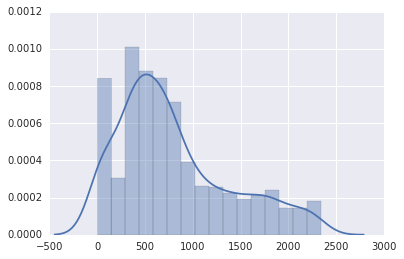

In [17]:
A = 'M90'
B = 'M80'

print "Checking data for {} -> {}".format(A, B)
(data_complete, schedule_times, actual_records, actual_times) = fetch_entries_for(A, B)
        
print "Actual Times:"
pprint.pprint(actual_times)
print "---"
print "Schedule Times:"
pprint.pprint(schedule_times)

print "---"
cutoff = actual_times._p95
print "Plotting distribution for P95 with cutoff time of {} seconds".format(cutoff)

list_times = [x._travel_time_secs for x in actual_records if (x._travel_time_secs < cutoff)]

#pprint.pprint(list_times)
sns_plot = sns.distplot(list_times)

# Spotting Issues on a Maps

To make it easier to see where we have incomplete data and where there are potential problem spots, we will plot these on a map of the region.

We will generate plots for each pairs of stations and export them in a local sub-folder.  We will also embedd thes images in a map that we produce.

In [18]:

(lat_c, lon_c) = get_map_center()

print (lat_c, lon_c)


(37.788134499999998, -122.18472385)


### Generating and Embedding plot images as iFrames 

In [19]:
import base64
from folium import IFrame

import matplotlib.pyplot as plt

PLOT_DIR_PREFIX = 'plots'
IMAGE_RESOLUTION = 75
IMAGE_WIDTH = 7
IMAGE_HEIGHT = 3

#
# TODO: Add Color Tags for the lines and the Pop Up
#
def generate_stats_image(A, B):
    """Generate and export the plots as PNG images in a sub-directory"""
    (data_complete, schedule_times, actual_records, actual_times) = fetch_entries_for(A, B)
    
    if data_complete:
        # Only generate graphs if we have all the data required.
        #
        # We will use a p95 cut-off or, the long tail can make the chart hard to see
        # We are essentially excluding the really large outliers - cancellation, breakdowns, etc.
        #
        cutoff = actual_times._p95
        list_times = [x._travel_time_secs for x in actual_records if (x._travel_time_secs < cutoff)]
        
        expected_duration = schedule_times._mode.mode[0] + DELAY_TOLERANCE
        list_diff = [(x - expected_duration)/60 for x in list_times ]

        # Start by clearning the plot and setting figure size.
        plt.clf()
        plt.figure(figsize=(IMAGE_WIDTH, IMAGE_HEIGHT))
        #ax = plt.axes()
        #sns_plot = sns.distplot(list_times, ax=ax)
        #label_a = get_station_name(A)
        #label_b = get_station_name(B)
        #ax.set_title("Trip distribution {} to {}".format(label_a, label_b))
        #ax.set(xlabel='Delay (mins)')
        plt.title('Delay Distribution (mins)', loc='right')
        sns_plot = sns.distplot(list_diff)
        
        #sns_plot = sns.kdeplot(list_diff, shade=True, color="r", cumulative=False)
        fig = sns_plot.get_figure()
        fig.savefig("{}/{}_to_{}.png".format(PLOT_DIR_PREFIX, A, B), dpi=IMAGE_RESOLUTION)
        plt.close()
        return True
    else:
        #print "Incomplete data for generating stats image for {} -> {}".format(A, B)
        return False
    
def get_image_iframe_popup(A, B, bg_color='#ffffff'):
    """Generates an iFrame components to embedd in a Folium Map"""
    file_name = '{}/{}_to_{}.png'.format(PLOT_DIR_PREFIX, A, B)
    label_a = get_station_name(A)
    label_b = get_station_name(B)
    (data_complete, schedule_times, actual_records, actual_times) = fetch_entries_for(A, B)
    n=actual_times._nobs
    
    expected_duration = (schedule_times._mode.mode[0] + DELAY_TOLERANCE)/60
    expected_duration = float("{0:.1f}".format(expected_duration))
    encoded = base64.b64encode(open(file_name, 'rb').read()).decode()
    html = '<p style="font-family:arial;background-color:{};">{} to {} (N={} Expected={} mins)</p><hr></h1><img src="data:image/png;base64,{}">'.format
    iframe = IFrame(html(bg_color, label_a, label_b, n, expected_duration, encoded), width=(IMAGE_WIDTH*IMAGE_RESOLUTION)+20, height=(IMAGE_HEIGHT*IMAGE_RESOLUTION)+40)
    popup = folium.Popup(iframe, max_width=2650)
    return popup

In [20]:
def get_rgb_color_for(level, max_levels=30):
    if level >= max_levels:
        level = max_levels-1
    if level < 0:
        level = 0
    pal = sns.color_palette("OrRd", max_levels)
    return pal.as_hex()[level]

NOBS_MAX = 1717
NOBS_MIN = 93
NOBS_RANGE = NOBS_MAX - NOBS_MIN

LINE_WIDTH_MAX = 20
LINE_WIDTH_MIN = 2

LINES_OFFSET = 0.0007

def get_travel_difference_color_and_width(A, B):
    ''''''
    (data_complete, schedule_times, actual_records, actual_times) = fetch_entries_for(A, B)
    
    color = get_rgb_color_for(0, max_levels=6)
    width = 2
    if data_complete:
        expected_duration = schedule_times._mode.mode[0] + DELAY_TOLERANCE
        actual_duration_median = actual_times._p50

        expected_duration /= 60
        actual_duration_median /= 60
        difference = (actual_duration_median - expected_duration)
        bucket = int(difference/5)
        color = get_rgb_color_for(bucket, max_levels=6)
        
        # Now for the width of the lines based on the number of observeations 
        #print "{}".format(actual_times._nobs)
        ratio = (float(actual_times._nobs) - NOBS_MIN)/ NOBS_RANGE
        #print "{} _ {}".format(ratio, actual_times._nobs)
        width = int(ratio * LINE_WIDTH_MAX) + LINE_WIDTH_MIN 
        #print "{} -> {}".format(color, width)
    return (color, width)

MAP_LINES_DRAWN={}

def draw_travel_lines(folium_map, A, B):
    """Travel Lines represet links between adjacent stations. The lines have a popup that shows statistics."""
    
    key = "{}_{}".format(A,B)
    if key in MAP_LINES_DRAWN:
        return
    
    MAP_LINES_DRAWN[key] = True
    key = "{}_{}".format(B,A)
    MAP_LINES_DRAWN[key] = True
    
    loc_a = get_station_lat_lon(A)
    loc_b = get_station_lat_lon(B)
    if loc_a is None or loc_b is None:
        # One of the location is not a valid BART station
        return
    
    # Generate A -> B line
    if generate_stats_image(A, B):
        loc_a = get_station_lat_lon(A, LINES_OFFSET)
        loc_b = get_station_lat_lon(B, LINES_OFFSET)
        points = [loc_a, loc_b]
        (line_color,line_width) = get_travel_difference_color_and_width(A,B)
        popup_iframe = get_image_iframe_popup(A, B, bg_color=line_color)
        folium.PolyLine(points, color=line_color, weight=line_width, opacity=0.7, popup=popup_iframe).add_to(folium_map)
    
    # 2. Now the image for B -> A
    if generate_stats_image(B, A):   
        loc_a = get_station_lat_lon(A, -LINES_OFFSET)
        loc_b = get_station_lat_lon(B, -LINES_OFFSET)
        points = [loc_b, loc_a]
        (line_color,line_width) = get_travel_difference_color_and_width(B,A)
        popup_iframe = get_image_iframe_popup(B, A, bg_color=line_color)
        folium.PolyLine(points, color=line_color, weight=line_width, opacity=0.7, popup=popup_iframe).add_to(folium_map)
    
def plot_travel_times(folium_map):
    """Given a Folium Map, adds travel lines"""
    for start, nested in map_actual_travel_times.iteritems():
        for end, actual_travel_stats in nested.iteritems():
            #if match > 60:
            #    break
            (data_complete, schedule_times, actual_records, actual_times) = fetch_entries_for(A, B)
            
            if data_complete:
                draw_travel_lines(folium_map, start, end)
    print "Drew {} lines on the map".format(len(MAP_LINES_DRAWN))

In [21]:
def mark_stations(folium_map):
    """Given a Folium Map, adds markers for all stations"""
    marker_cluster = folium.MarkerCluster().add_to(folium_map)
    for idx, row in bart_locations.iterrows():
        #print row['station_ch3_abbr'], row['gtfs_latitude'], row['station_name']
        lon = row['gtfs_longitude']
        lat = row['gtfs_latitude']
        label = row['station_name']
        folium.Marker([lat, lon], popup=label).add_to(marker_cluster)

# Visual Styles -
# tiles='Stamen Terrain'
# tiles='CartoDB dark_matter' - > Black
# tiles='CartoDB positron

map_light = folium.Map(location=[lat_c, lon_c], tiles='CartoDB positron', zoom_start=12)
mark_stations(map_light)
plot_travel_times(map_light)
map_light.save('delay_hot_spots_light.html')

Couldn't find M55
Couldn't find A05
Couldn't find R65
Couldn't find C85
Couldn't find C85
Couldn't find C75
Couldn't find C85
Couldn't find C75
Couldn't find S20
Couldn't find L35
Couldn't find C85
Couldn't find S20
Couldn't find A85
Couldn't find C85
Couldn't find R65
Couldn't find S20
Couldn't find L35
Couldn't find S20
Couldn't find L35
Couldn't find R65
Couldn't find R65
Couldn't find M87
Couldn't find M87
Couldn't find S15
Couldn't find S20
Couldn't find L35
Couldn't find R65
Couldn't find R65
Couldn't find R65
Couldn't find R65
Couldn't find C85
Couldn't find M55
Couldn't find S20
Couldn't find L35
Couldn't find C85
Couldn't find C85
Couldn't find M17
Couldn't find A85
Couldn't find W25
Couldn't find L35
Couldn't find M17
Couldn't find C85
Couldn't find W25
Couldn't find S20
Couldn't find S15
Couldn't find S20
Couldn't find L35
Couldn't find A05
Couldn't find A05
Couldn't find L13
Couldn't find C85
Couldn't find C85
Couldn't find C75
Couldn't find C85
Couldn't find M87
Couldn't f

In [22]:
map_dark = folium.Map(location=[lat_c, lon_c], tiles='CartoDB dark_matter', zoom_start=12)
mark_stations(map_dark)
MAP_LINES_DRAWN = {} # Clear lines map 
plot_travel_times(map_dark)
map_dark.save('delay_hot_spots_dark.html')

Couldn't find M55
Couldn't find A05
Couldn't find R65
Couldn't find C85
Couldn't find C85
Couldn't find C75
Couldn't find C85
Couldn't find C75
Couldn't find S20
Couldn't find L35
Couldn't find C85
Couldn't find S20
Couldn't find A85
Couldn't find C85
Couldn't find R65
Couldn't find S20
Couldn't find L35
Couldn't find S20
Couldn't find L35
Couldn't find R65
Couldn't find R65
Couldn't find M87
Couldn't find M87
Couldn't find S15
Couldn't find S20
Couldn't find L35
Couldn't find R65
Couldn't find R65
Couldn't find R65
Couldn't find R65
Couldn't find C85
Couldn't find M55
Couldn't find S20
Couldn't find L35
Couldn't find C85
Couldn't find C85
Couldn't find M17
Couldn't find A85
Couldn't find W25
Couldn't find L35
Couldn't find M17
Couldn't find C85
Couldn't find W25
Couldn't find S20
Couldn't find S15
Couldn't find S20
Couldn't find L35
Couldn't find A05
Couldn't find A05
Couldn't find L13
Couldn't find C85
Couldn't find C85
Couldn't find C75
Couldn't find C85
Couldn't find M87
Couldn't f

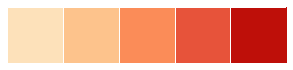

In [23]:
sns.palplot(sns.color_palette("OrRd", 5))
# https://chrisalbon.com/python/seaborn_color_palettes.html